<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>
<hr/>
<font color="#800080" size=5>
Assignment 2 : Deep Autoregressive Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
<hr>
<font color='red'  size=4>
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @ZahraSorkhei, @Ali99os
</font>
<br>
<hr>
</div></font>

**You should only change the blank sections, marked with TODO**

Pay attention to docstrings, as they may drastically help with your implementation.

You are advised to read all related papers and material, to help you better understand the design of each model.

# Question 1: Probabilistic Graph Forecasting with Autoregressive Decoders

This note gives a concise introduction to a temporal latent-variable model for **graph sequences** $\{G_t\}_{t=1}^T$ with $G_t=(X_t,A_t)$. It states the model, the training objective (ELBO) in a time-factorized form, the concrete likelihoods used for node features and edges, the effect of a deterministic decoder, and how to generate future graphs.



## Problem setup

We observe a sequence of graph snapshots

$$
G_t = (X_t, A_t), \quad t=1,\dots,T,
$$

where $X_t \in \mathbb{R}^{n \times d}$ stacks node feature vectors $x_t^v$ and $A_t \in \{0,1\}^{n \times n}$ is an undirected adjacency matrix (no self-loops). To capture temporal structure we introduce a latent trajectory

$$
Z_{1:T} = (Z_1, \dots, Z_T), \quad Z_t \in \mathbb{R}^m,
$$

where $Z_t$ is a global latent representation of the whole graph at time $t$.


## Generative (autoregressive latent) model

An autoregressive factorization is used:

$$
p_\theta(X_{1:T}, A_{1:T}, Z_{1:T})
= p(Z_1) \prod_{t=1}^{T-1} p_\theta(Z_{t+1}\mid Z_t)\; p_\theta(X_{t+1}, A_{t+1}\mid Z_t)
$$

Intuition: the latent $Z_t$ summarizes the state at $t$; a transition model $p_\theta(Z_{t+1}\mid Z_t)$ evolves it; conditioned on the current latent we predict the *next* snapshot $(X_{t+1}, A_{t+1})$.

We approximate the true posterior with an amortized encoder (e.g. a GNN+RNN):

$$
q_\phi(Z_t \mid X_{1:t}, A_{1:t}) \quad \text{(often factorized across $t$ for amortization).}
$$


## Variational lower bound (ELBO) — time decomposition

Using the variational approximation

$$
q_\phi(Z_{1:T}\mid X_{1:T},A_{1:T}) = \prod_{t=1}^T q_\phi(Z_t \mid X_{1:t},A_{1:t}),
$$

the marginal log-likelihood admits the ELBO:

$$
\log p_\theta(X_{1:T}, A_{1:T}) \ge
\mathbb{E}_{q_\phi} \Big[ \sum_{t=1}^{T-1} \log p_\theta(X_{t+1}, A_{t+1} \mid Z_t) \Big]
- \mathrm{KL}\big(q_\phi(Z_1 \mid X_1, A_1) \,\|\, p(Z_1)\big)
- \sum_{t=1}^{T-1} \mathbb{E}_{q_\phi} \Big[ \mathrm{KL}\big(q_\phi(Z_{t+1}\mid X_{1:t+1}, A_{1:t+1}) \,\|\, p_\theta(Z_{t+1}\mid Z_t)\big) \Big].
$$

Thus the objective is a sum over time: per-step reconstruction terms plus per-step KL penalties that align the encoder's posterior with the learned transition prior.



## Explicit reconstruction likelihoods

If the decoder factorizes into Gaussian node-features and Bernoulli edges:

- **Node features (per node $v$)**

$$
p_\theta(x_{t+1}^v \mid Z_t) = \mathcal{N}(x_{t+1}^v \mid \mu_\theta^v(Z_t), \Sigma_\theta^v(Z_t)),
$$

hence the feature log-likelihood (for all nodes) is

$$
\log p_\theta(X_{t+1} \mid Z_t)
= -\frac{1}{2} \sum_{v=1}^n \Big[ (x_{t+1}^v - \mu_\theta^v)^\top (\Sigma_\theta^v)^{-1} (x_{t+1}^v - \mu_\theta^v) + \log \det(2 \pi \Sigma_\theta^v) \Big].
$$

(In practice $\Sigma^v$ is taken diagonal or shared for numerical stability.)

- **Edges (for unordered pairs $u<v$)**

$$
p_\theta(A_{t+1} \mid Z_t) = \prod_{u<v} \mathrm{Bernoulli}\big(A_{t+1}^{uv} \mid \pi_\theta^{uv}(Z_t)\big),
$$

so

$$
\log p_\theta(A_{t+1} \mid Z_t) = \sum_{u<v} \Big[ A_{uv} \log \pi_{uv} + (1-A_{uv}) \log (1-\pi_{uv}) \Big].
$$

Combine them:

$$
\log p_\theta(X_{t+1}, A_{t+1} \mid Z_t) = \log p_\theta(X_{t+1} \mid Z_t) + \log p_\theta(A_{t+1} \mid Z_t).
$$


## Deterministic decoder

If the decoder is deterministic (e.g. $X_{t+1}=f_\theta(Z_t)$, $A_{t+1}=g_\theta(Z_t)$ or equivalently Gaussian with vanishing variance), then:

- The likelihood becomes a Dirac (or degenerate Gaussian); log-likelihood is $-\infty$ off the model manifold — numerically unstable.
- Deterministic decoders cannot model multimodality: a single $Z_t$ maps to a single snapshot, so they fail when the conditional distribution is multi-valued.
- Training tends to overfit (model memorizes) or produce poor uncertainty calibration. Probabilistic decoders (non-zero variance, Bernoulli edges) are preferred for stable likelihood-based training and to capture uncertainty/diversity.


## Generating future graphs

Given observed history $X_{1:T}, A_{1:T}$:

1. Infer the posterior at final time: $q_\phi(Z_T \mid X_{1:T}, A_{1:T})$ and sample $z_T \sim q_\phi$ (or use the posterior mean).
2. For $h=1$ to $H$:
   - Sample latent: $z_{T+h} \sim p_\theta(Z_{T+h} \mid z_{T+h-1})$.
   - Sample (or take mean of) snapshot: $(\tilde X_{T+h}, \tilde A_{T+h}) \sim p_\theta(\cdot \mid z_{T+h-1})$ (or use the decoder mean).





In [ ]:
import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

## 1) Synthetic dynamic graph dataset
**Goal:**  
Create dynamic graphs using SBM with Gaussian node features.

**Hints:**  
- `generate_sbm`: adjacency with `p_in` (intra) and `p_out` (inter) edges.  
- `generate_features`: node features from `N(μ_k, Σ_k)` per community.  
- `generate_sequence`: simulate T timesteps with drift and edge flips.  
- `_getitem_` / `_len_`: return sequences.  
- `collate_fn`: batch multiple sequences.

**Output:**  
- `X_seq`: `[T, n_nodes, feat_dim]`  
- `A_seq`: `[T, n_nodes, n_nodes]`

In [ ]:
class SyntheticGraphDataset(Dataset):
    """
    Generate synthetic evolving graphs.
    - Each sequence has T snapshots.
    - Node features: random walk.
    - Edges: flip with small probability.
    """
    def __init__(self, n_nodes=30, feat_dim=4, T=30, n_seq=200, p_flip=0.01):
        self.n_nodes = n_nodes
        self.feat_dim = feat_dim
        self.T = T
        self.n_seq = n_seq
        self.p_flip = p_flip
        self.data = []
        for _ in range(n_seq):
            self.data.append(self.generate_sequence())

    def generate_sequence(self):
        n_comm = 3
        nodes_per_comm = self.n_nodes // n_comm

        p_in = 0.4
        p_out = 0.05
        prob_matrix = torch.zeros((self.n_nodes, self.n_nodes))

        for i in range(self.n_nodes):
            for j in range(self.n_nodes):
                if (i // nodes_per_comm) == (j // nodes_per_comm):
                    prob_matrix[i, j] = p_in
                else:
                    prob_matrix[i, j] = p_out

        A0 = torch.bernoulli(prob_matrix)
        A0 = torch.triu(A0, 1)
        A0 = A0 + A0.t()

        X0 = torch.zeros((self.n_nodes, self.feat_dim))
        mu_scale = 1.5
        for i in range(self.n_nodes):
            mu = mu_scale if (i // nodes_per_comm) == 0 else -mu_scale
            X0[i] = torch.normal(mean=mu, std=0.3, size=(self.feat_dim,))

        X_seq = [X0]
        A_seq = [A0]

        X_curr = X0
        A_curr = A0

        for t in range(1, self.T):
            noise = torch.randn_like(X_curr) * 0.05
            X_next = X_curr + noise

            flip_mask = torch.bernoulli(torch.full((self.n_nodes, self.n_nodes), self.p_flip))
            flip_mask = torch.triu(flip_mask, 1)
            flip_mask = flip_mask + flip_mask.t()

            A_next = torch.abs(A_curr - flip_mask)
            A_next.fill_diagonal_(0)

            X_seq.append(X_next)
            A_seq.append(A_next)

            X_curr = X_next
            A_curr = A_next

        return torch.stack(X_seq), torch.stack(A_seq)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def collate_fn(batch):
    x_batch, a_batch = zip(*batch)
    return torch.stack(x_batch), torch.stack(a_batch)

## 2) Encoder, Prior, Decoder

### SimpleGraphEncoder
Aggregates node features and degree statistics.  
Computes graph-level latent embeddings `mu` and `logvar` for VAE.  
No external graph libraries required; uses only PyTorch.

### TransitionPrior
Models the latent temporal evolution `p(Z_{t+1} | Z_t)` as a Gaussian.  
Produces mean and variance for autoregressive sampling in VAE.

### Decoder
Reconstructs node features and adjacency matrices from latent `Z_t`.  
Uses node embeddings combined with latent vectors for feature decoding.  
Produces edge logits for Bernoulli reconstruction of adjacency.  
Supports probabilistic reconstruction via Gaussian features + Bernoulli edges.

In [ ]:
class SimpleGraphEncoder(nn.Module):
    """
    Simple encoder that aggregates node features and graph degree stats.
    No torch_geometric needed.
    """
    def __init__(self, n_nodes, feat_dim, hidden_dim, latent_dim):
        super(SimpleGraphEncoder, self).__init__()
        self.n_nodes = n_nodes
        self.feat_encoder = nn.Linear(feat_dim + 1, hidden_dim)
        self.gcn1 = nn.Linear(hidden_dim, hidden_dim)
        self.gcn2 = nn.Linear(hidden_dim, hidden_dim)
        self.gcn3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x, a):
        deg = a.sum(dim=-1, keepdim=True)
        deg = deg / (self.n_nodes)
        x_aug = torch.cat([x, deg], dim=-1)
        h = self.act(self.feat_encoder(x_aug))

        a_self = a + torch.eye(self.n_nodes, device=x.device).unsqueeze(0)
        d_inv = 1.0 / (a_self.sum(dim=-1, keepdim=True) + 1e-6)
        a_norm = a_self * d_inv

        h_res = h
        h = self.act(self.gcn1(torch.bmm(a_norm, h)))
        h = h + h_res

        h_res = h
        h = self.act(self.gcn2(torch.bmm(a_norm, h)))
        h = h + h_res

        h_res = h
        h = self.act(self.gcn3(torch.bmm(a_norm, h)))
        h = h + h_res

        h_g = h.mean(dim=1)

        mu = self.fc_mu(h_g)
        logvar = self.fc_logvar(h_g)
        return mu, logvar


class TransitionPrior(nn.Module):
    """ p(Z_{t+1}|Z_t) Gaussian """
    def __init__(self, latent_dim, hidden_dim):
        super(TransitionPrior, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1)
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, z_t):
        h = self.net(z_t)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu + z_t, logvar


class Decoder(nn.Module):
    """ Decode node features and edges from Z_t """
    def __init__(self, n_nodes, feat_dim, latent_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.n_nodes = n_nodes

        self.node_emb = nn.Parameter(torch.randn(1, n_nodes, hidden_dim) * 0.1)
        self.z_proj = nn.Linear(latent_dim, hidden_dim)

        self.decoder_net = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.1)
        )

        self.feat_mu_head = nn.Linear(hidden_dim, feat_dim)
        self.feat_logvar_head = nn.Linear(hidden_dim, feat_dim)
        self.edge_proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, z_t):
        B = z_t.size(0)

        z_expand = self.z_proj(z_t).unsqueeze(1).expand(-1, self.n_nodes, -1)
        n_expand = self.node_emb.expand(B, -1, -1)

        combined = torch.cat([z_expand, n_expand], dim=-1)
        h = self.decoder_net(combined)

        x_mu = self.feat_mu_head(h)
        x_logvar = self.feat_logvar_head(h)

        h_edge = self.edge_proj(h)
        adj_logits = torch.bmm(h_edge, h_edge.transpose(1, 2))

        eye = torch.eye(self.n_nodes, device=adj_logits.device).unsqueeze(0).expand(B, -1, -1)
        adj_logits = adj_logits.masked_fill(eye.bool(), -1e9)

        return x_mu, x_logvar, adj_logits

`reparameterize`: samples latent variable using the reparameterization trick.  
`kl_gauss`: closed-form KL divergence between two Gaussians.  
`nll_gaussian`: negative log-likelihood for node features.  
`nll_bernoulli`: negative log-likelihood (binary cross-entropy) for edges.

In [ ]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std


def kl_gauss(mu_q, logvar_q, mu_p, logvar_p):
    """ closed-form KL(q||p) """
    logvar_q = torch.clamp(logvar_q, -10, 10)
    logvar_p = torch.clamp(logvar_p, -10, 10)
    kl = 0.5 * (logvar_p - logvar_q - 1 + (torch.exp(logvar_q) + (mu_q - mu_p).pow(2)) / torch.exp(logvar_p))
    return torch.sum(kl)


def nll_gaussian(x, mu, logvar):
    logvar = torch.clamp(logvar, min=-10, max=10)
    loss = 0.5 * (np.log(2 * np.pi) + logvar + (x - mu).pow(2) / torch.exp(logvar))
    return torch.sum(loss)


def nll_bernoulli(logits, target):
    loss = F.binary_cross_entropy_with_logits(logits, target, reduction='sum')
    return loss

## 4) TemporalGraphVAE
Define the Temporal Graph VAE model.  
- Encode node features & adjacency into latent `z`.  
- Model transitions `p(z_{t+1}|z_t)`.  
- Decode `z` to reconstruct node features and edges.  
- Compute ELBO (reconstruction + KL) for training.

In [ ]:
class TemporalGraphVAE(nn.Module):
    def __init__(self, n_nodes, feat_dim, z_dim=16):
        super().__init__()
        hidden_dim = 256
        self.encoder = SimpleGraphEncoder(n_nodes, feat_dim, hidden_dim, z_dim)
        self.transition = TransitionPrior(z_dim, hidden_dim)
        self.decoder = Decoder(n_nodes, feat_dim, z_dim, hidden_dim)
        self.z_dim = z_dim

    def forward(self, X_seq, A_seq, kl_weight=1.0):
        B, T, N, F = X_seq.shape
        kl_loss = 0
        recon_loss = 0

        z_prev = None

        for t in range(T):
            x_t = X_seq[:, t, :, :]
            a_t = A_seq[:, t, :, :]

            mu_q, logvar_q = self.encoder(x_t, a_t)
            z_t = reparameterize(mu_q, logvar_q)

            if t == 0:
                mu_p = torch.zeros_like(mu_q)
                logvar_p = torch.zeros_like(logvar_q)
            else:
                mu_p, logvar_p = self.transition(z_prev)

            kl_loss += kl_gauss(mu_q, logvar_q, mu_p, logvar_p)

            if t < T - 1:
                x_next_gt = X_seq[:, t + 1, :, :]
                a_next_gt = A_seq[:, t + 1, :, :]

                x_recon_mu, x_recon_logvar, a_recon_logits = self.decoder(z_t)

                loss_x = nll_gaussian(x_next_gt, x_recon_mu, x_recon_logvar)
                loss_a = nll_bernoulli(a_recon_logits, a_next_gt)
                recon_loss += (loss_x + loss_a)

            z_prev = z_t

        loss = (recon_loss + kl_weight * kl_loss) / B
        return loss, recon_loss / B, kl_loss / B

## 5) Visualization helpers

In [ ]:
def visualize_graphs(A_true, A_recon_probs, communities, epoch, K, p_in, p_out):
    A_recon_bin = (A_recon_probs >= 0.5).astype(int)
    G_true, G_recon = nx.from_numpy_array(A_true), nx.from_numpy_array(A_recon_bin)
    pos = nx.spring_layout(G_true, seed=42)
    plt.figure(figsize=(9, 4))
    plt.suptitle(f"SBM Graphs (Epoch {epoch})\n"
                 f"K={K}, Intra={p_in}, Inter={p_out}\n"
                 f"In each component: X~N(μ_k, Σ_k)", fontsize=10)
    plt.subplot(1, 2, 1)
    nx.draw(G_true, pos, node_color=communities, cmap='tab10', node_size=100, with_labels=False, alpha=0.8)
    plt.title("True graph")
    plt.subplot(1, 2, 2)
    nx.draw(G_recon, pos, node_color=communities, cmap='tab10', node_size=100, with_labels=False, alpha=0.8)
    plt.title("Reconstructed (p≥0.5)")
    plt.tight_layout()
    plt.show()


## 6) Training
Train the Temporal Graph VAE.  
- Loop over epochs and batches.  
- Forward pass, compute loss, backprop, optimizer step.  
- Track and print losses (`Total`, `Recon`, `KL`).  
- Optionally visualize true vs reconstructed graphs every `vis_interval`.

In [ ]:
def train_model(vis_interval=10, epochs=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset = SyntheticGraphDataset(n_nodes=30, feat_dim=4, T=30, n_seq=200, p_flip=0.005)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

    model = TemporalGraphVAE(n_nodes=30, feat_dim=4, z_dim=32).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    communities = np.concatenate([np.zeros(15), np.ones(15)]).astype(int)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss_epoch = 0
        total_recon_epoch = 0
        total_kl_epoch = 0

        kl_weight = min(0.1, epoch * 0.002)

        for batch_idx, (X_seq, A_seq) in enumerate(dataloader):
            X_seq = X_seq.to(device)
            A_seq = A_seq.to(device)

            optimizer.zero_grad()
            loss, recon, kl = model(X_seq, A_seq, kl_weight=kl_weight)

            if torch.isnan(loss):
                continue

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss_epoch += loss.item()
            total_recon_epoch += recon.item()
            total_kl_epoch += kl.item()

        avg_loss = total_loss_epoch / len(dataloader)
        avg_recon = total_recon_epoch / len(dataloader)
        avg_kl = total_kl_epoch / len(dataloader)

        print(f"Epoch {epoch:03d} | Loss: {avg_loss:.2f} | Recon: {avg_recon:.2f} | KL: {avg_kl:.2f} | kl_w: {kl_weight:.4f}")

        if epoch % vis_interval == 0:
            model.eval()
            with torch.no_grad():
                X_sample, A_sample = dataset[0]
                X_sample = X_sample.unsqueeze(0).to(device)
                A_sample = A_sample.unsqueeze(0).to(device)

                t = 15
                x_t = X_sample[:, t, :, :]
                a_t = A_sample[:, t, :, :]

                a_target = A_sample[:, t + 1, :, :].squeeze(0).cpu().numpy()

                mu, logvar = model.encoder(x_t, a_t)
                z = reparameterize(mu, logvar)
                _, _, adj_logits = model.decoder(z)

                probs = torch.sigmoid(adj_logits).squeeze(0).cpu().numpy()

                visualize_graphs(a_target, probs, communities, epoch, K=3, p_in=0.6, p_out=0.05)

    torch.save(model.state_dict(), "temporal_graph_vae_sbm.pth")
    print("✅ Model saved: temporal_graph_vae_sbm.pth")

    return model, dataset

## 7) Testing
Evaluate the trained model on sample sequences.  
- Encode last snapshot, decode to get reconstructed adjacency/features.  
- Compute simple metrics (e.g., edge accuracy).  
- Visualize true vs reconstructed graphs for verification.

In [ ]:
def test_model(model, dataset):
    device = next(model.parameters()).device

    model.load_state_dict(torch.load("temporal_graph_vae_sbm.pth"))
    print("✅ Model loaded from: temporal_graph_vae_sbm.pth")

    model.eval()

    total_acc = 0
    count = 0
    communities = np.concatenate([np.zeros(15), np.ones(15)]).astype(int)

    with torch.no_grad():
        for i in range(10):
            X_seq, A_seq = dataset[i]
            X_seq = X_seq.unsqueeze(0).to(device)
            A_seq = A_seq.unsqueeze(0).to(device)

            T = X_seq.shape[1]
            x_last = X_seq[:, T-2, :, :]
            a_last = A_seq[:, T-2, :, :]
            a_target = A_seq[:, T-1, :, :]

            mu, logvar = model.encoder(x_last, a_last)
            z = reparameterize(mu, logvar)
            _, _, adj_logits = model.decoder(z)

            probs = torch.sigmoid(adj_logits)
            preds = (probs >= 0.5).float()

            acc = (preds == a_target).float().mean()
            total_acc += acc.item()
            count += 1

            if i == 0:
                a_true_np = a_target.squeeze().cpu().numpy()
                probs_np = probs.squeeze().cpu().numpy()
                visualize_graphs(a_true_np, probs_np, communities, "Test", K=3, p_in=0.6, p_out=0.05)

    print(f"Test accuracy: {total_acc / count:.4f}")

## 8) Train and Test


**The final result can be much better than the displayed result.**

Epoch 001 | Loss: 27449.44 | Recon: 27448.55 | KL: 445.40 | kl_w: 0.0020
Epoch 002 | Loss: 24443.07 | Recon: 24438.32 | KL: 1185.90 | kl_w: 0.0040
Epoch 003 | Loss: 23765.53 | Recon: 23753.68 | KL: 1974.70 | kl_w: 0.0060
Epoch 004 | Loss: 22767.71 | Recon: 22755.30 | KL: 1551.76 | kl_w: 0.0080
Epoch 005 | Loss: 22065.70 | Recon: 22055.48 | KL: 1021.86 | kl_w: 0.0100


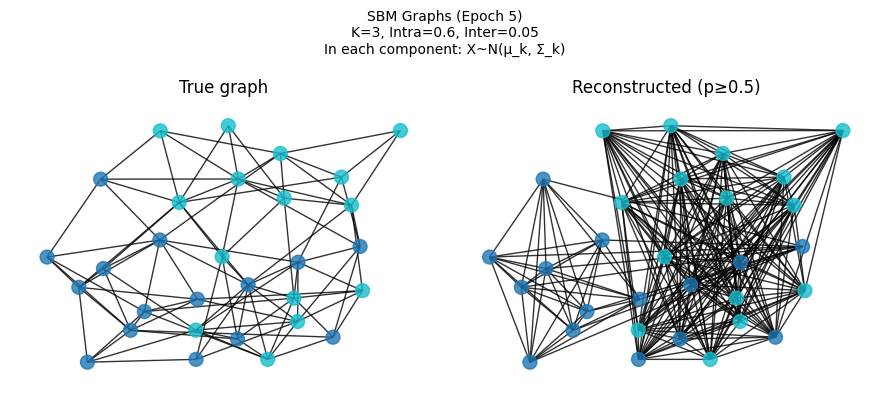

Epoch 006 | Loss: 21015.99 | Recon: 21002.43 | KL: 1130.56 | kl_w: 0.0120
Epoch 007 | Loss: 19842.33 | Recon: 19830.73 | KL: 828.25 | kl_w: 0.0140
Epoch 008 | Loss: 18846.51 | Recon: 18832.51 | KL: 875.15 | kl_w: 0.0160
Epoch 009 | Loss: 18311.60 | Recon: 18295.36 | KL: 902.44 | kl_w: 0.0180
Epoch 010 | Loss: 18073.32 | Recon: 18061.77 | KL: 577.61 | kl_w: 0.0200


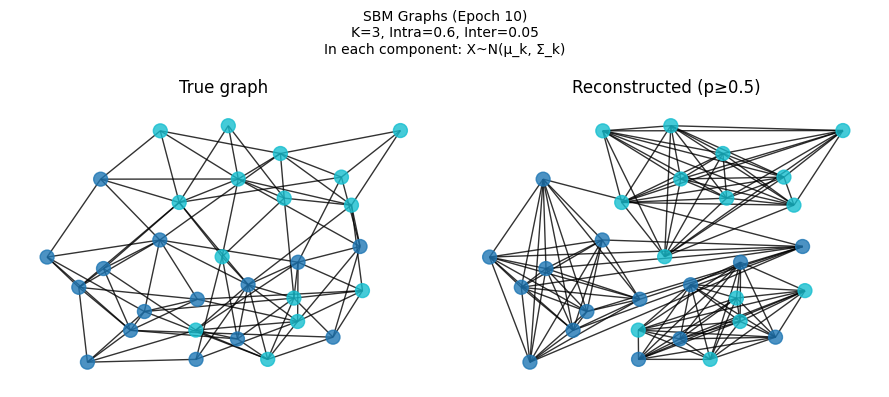

Epoch 011 | Loss: 17893.73 | Recon: 17882.62 | KL: 504.81 | kl_w: 0.0220
Epoch 012 | Loss: 17840.06 | Recon: 17829.93 | KL: 421.81 | kl_w: 0.0240
Epoch 013 | Loss: 17702.78 | Recon: 17692.68 | KL: 388.62 | kl_w: 0.0260
Epoch 014 | Loss: 17768.19 | Recon: 17757.47 | KL: 382.82 | kl_w: 0.0280
Epoch 015 | Loss: 17729.87 | Recon: 17718.54 | KL: 377.55 | kl_w: 0.0300


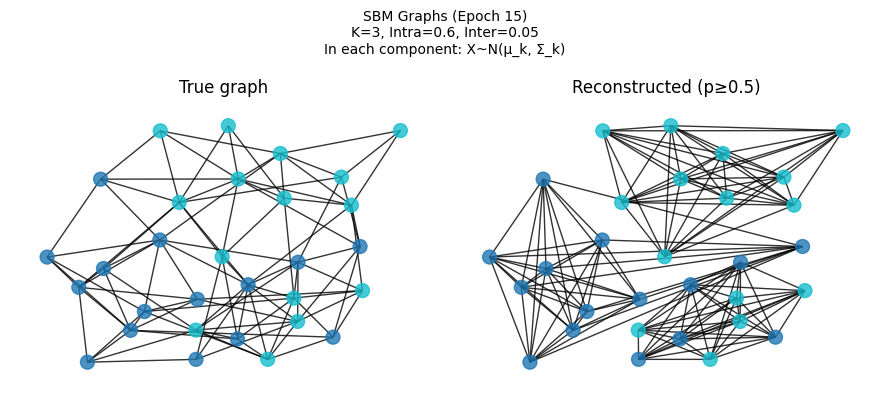

Epoch 016 | Loss: 17714.57 | Recon: 17702.55 | KL: 375.62 | kl_w: 0.0320
Epoch 017 | Loss: 17725.24 | Recon: 17712.52 | KL: 374.12 | kl_w: 0.0340
Epoch 018 | Loss: 17707.07 | Recon: 17693.58 | KL: 374.63 | kl_w: 0.0360
Epoch 019 | Loss: 17745.39 | Recon: 17731.12 | KL: 375.63 | kl_w: 0.0380
Epoch 020 | Loss: 17710.26 | Recon: 17695.33 | KL: 373.17 | kl_w: 0.0400


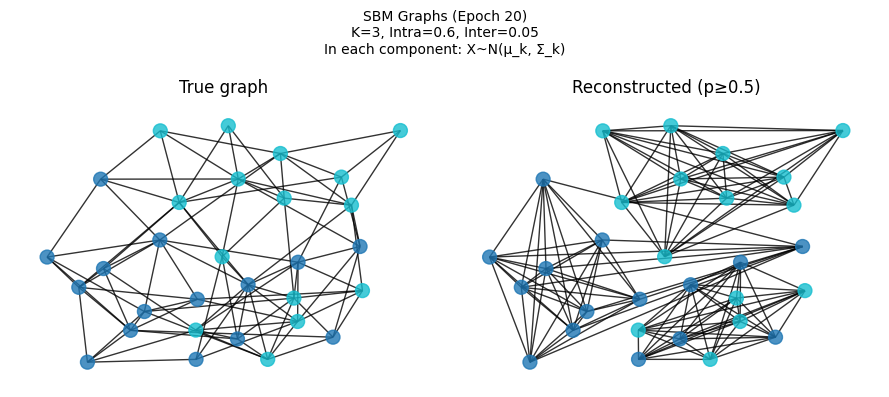

Epoch 021 | Loss: 17698.10 | Recon: 17682.43 | KL: 372.88 | kl_w: 0.0420
Epoch 022 | Loss: 17703.15 | Recon: 17686.21 | KL: 385.10 | kl_w: 0.0440
Epoch 023 | Loss: 17696.06 | Recon: 17678.54 | KL: 380.92 | kl_w: 0.0460
Epoch 024 | Loss: 17661.61 | Recon: 17643.78 | KL: 371.49 | kl_w: 0.0480
Epoch 025 | Loss: 17692.32 | Recon: 17674.04 | KL: 365.63 | kl_w: 0.0500


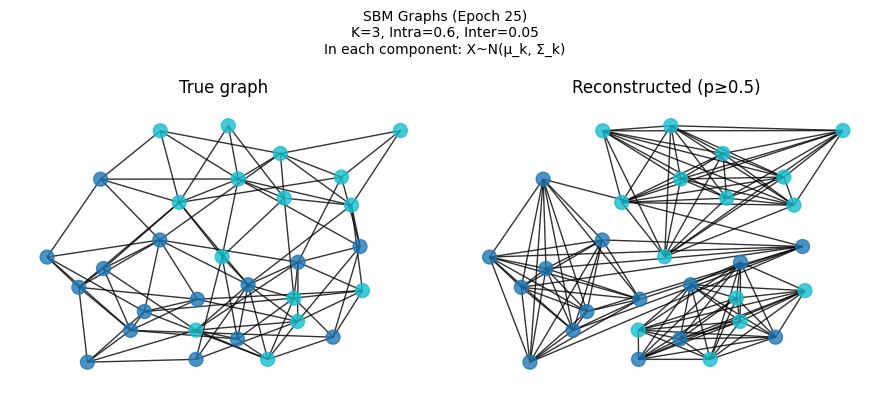

Epoch 026 | Loss: 17679.28 | Recon: 17659.93 | KL: 372.19 | kl_w: 0.0520
Epoch 027 | Loss: 17695.29 | Recon: 17675.36 | KL: 369.07 | kl_w: 0.0540
Epoch 028 | Loss: 17669.40 | Recon: 17649.33 | KL: 358.41 | kl_w: 0.0560
Epoch 029 | Loss: 17657.73 | Recon: 17637.32 | KL: 351.86 | kl_w: 0.0580
Epoch 030 | Loss: 17672.88 | Recon: 17651.66 | KL: 353.64 | kl_w: 0.0600


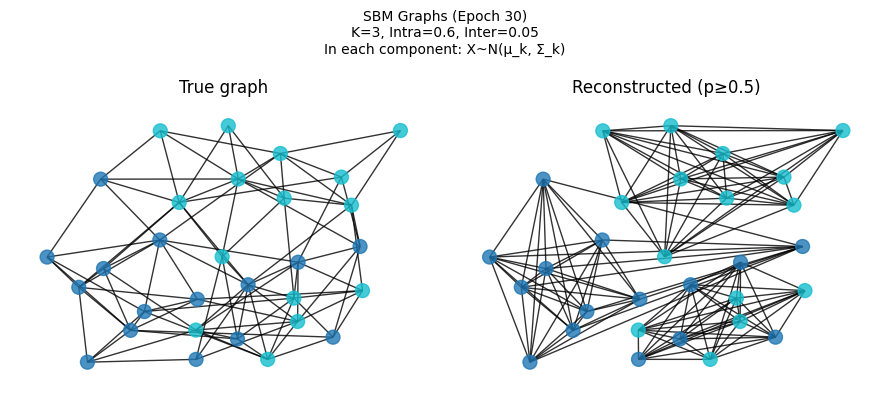

Epoch 031 | Loss: 17652.39 | Recon: 17630.89 | KL: 346.82 | kl_w: 0.0620
Epoch 032 | Loss: 17656.28 | Recon: 17634.38 | KL: 342.31 | kl_w: 0.0640
Epoch 033 | Loss: 17688.72 | Recon: 17665.79 | KL: 347.45 | kl_w: 0.0660
Epoch 034 | Loss: 17678.88 | Recon: 17656.80 | KL: 324.74 | kl_w: 0.0680
Epoch 035 | Loss: 17640.43 | Recon: 17618.74 | KL: 309.96 | kl_w: 0.0700


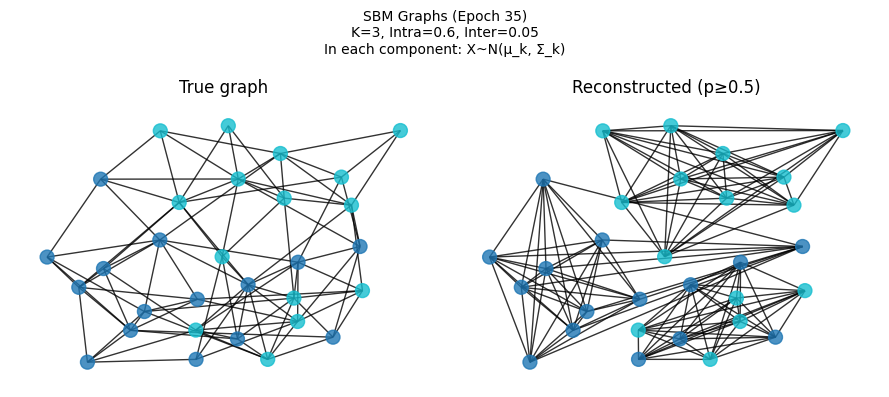

Epoch 036 | Loss: 17661.88 | Recon: 17639.75 | KL: 307.37 | kl_w: 0.0720
Epoch 037 | Loss: 17662.67 | Recon: 17640.65 | KL: 297.63 | kl_w: 0.0740
Epoch 038 | Loss: 17662.75 | Recon: 17640.89 | KL: 287.65 | kl_w: 0.0760
Epoch 039 | Loss: 17625.54 | Recon: 17602.96 | KL: 289.60 | kl_w: 0.0780
Epoch 040 | Loss: 17637.04 | Recon: 17613.50 | KL: 294.33 | kl_w: 0.0800


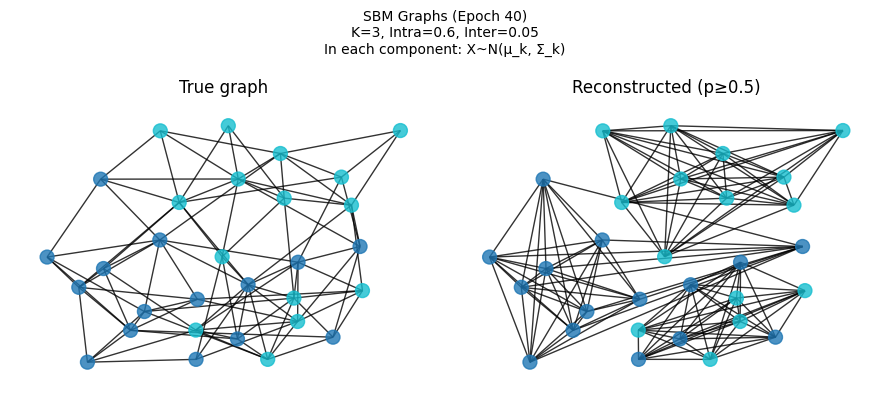

Epoch 041 | Loss: 17586.16 | Recon: 17563.83 | KL: 272.35 | kl_w: 0.0820
Epoch 042 | Loss: 17592.18 | Recon: 17569.80 | KL: 266.46 | kl_w: 0.0840
Epoch 043 | Loss: 17572.90 | Recon: 17550.48 | KL: 260.77 | kl_w: 0.0860
Epoch 044 | Loss: 17525.84 | Recon: 17504.14 | KL: 246.65 | kl_w: 0.0880
Epoch 045 | Loss: 17495.53 | Recon: 17473.20 | KL: 248.10 | kl_w: 0.0900


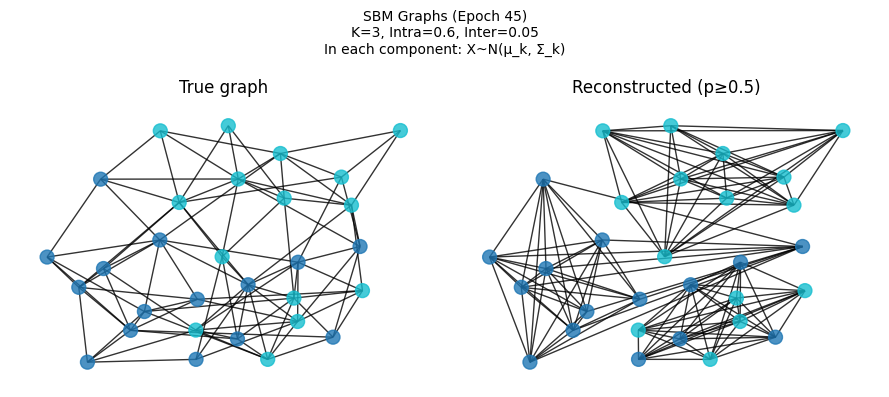

Epoch 046 | Loss: 17410.34 | Recon: 17387.53 | KL: 247.96 | kl_w: 0.0920
Epoch 047 | Loss: 17272.23 | Recon: 17250.81 | KL: 227.83 | kl_w: 0.0940
Epoch 048 | Loss: 17256.43 | Recon: 17235.52 | KL: 217.82 | kl_w: 0.0960
Epoch 049 | Loss: 17142.72 | Recon: 17122.31 | KL: 208.29 | kl_w: 0.0980
Epoch 050 | Loss: 17162.86 | Recon: 17142.09 | KL: 207.70 | kl_w: 0.1000


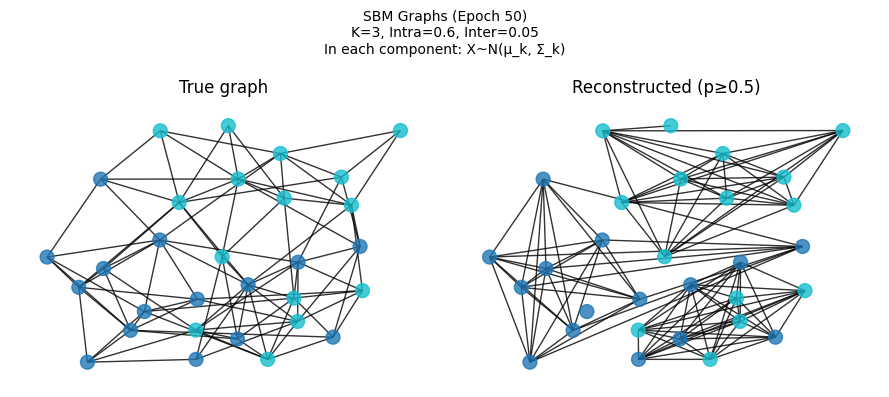

Epoch 051 | Loss: 17134.25 | Recon: 17113.74 | KL: 205.12 | kl_w: 0.1000
Epoch 052 | Loss: 17153.37 | Recon: 17133.23 | KL: 201.39 | kl_w: 0.1000
Epoch 053 | Loss: 17112.83 | Recon: 17091.35 | KL: 214.81 | kl_w: 0.1000
Epoch 054 | Loss: 17167.34 | Recon: 17145.91 | KL: 214.22 | kl_w: 0.1000
Epoch 055 | Loss: 17110.07 | Recon: 17089.73 | KL: 203.38 | kl_w: 0.1000


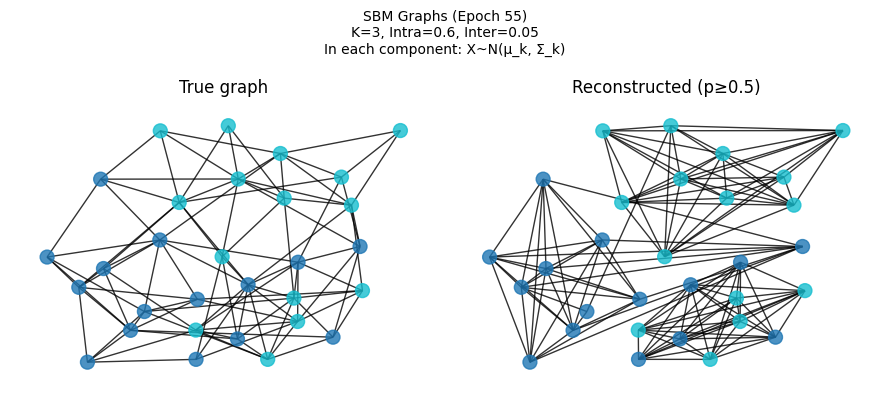

Epoch 056 | Loss: 17109.42 | Recon: 17089.22 | KL: 202.03 | kl_w: 0.1000
Epoch 057 | Loss: 17144.65 | Recon: 17124.63 | KL: 200.24 | kl_w: 0.1000
Epoch 058 | Loss: 16986.04 | Recon: 16966.23 | KL: 198.13 | kl_w: 0.1000
Epoch 059 | Loss: 16919.97 | Recon: 16900.96 | KL: 190.09 | kl_w: 0.1000
Epoch 060 | Loss: 16987.07 | Recon: 16966.04 | KL: 210.39 | kl_w: 0.1000


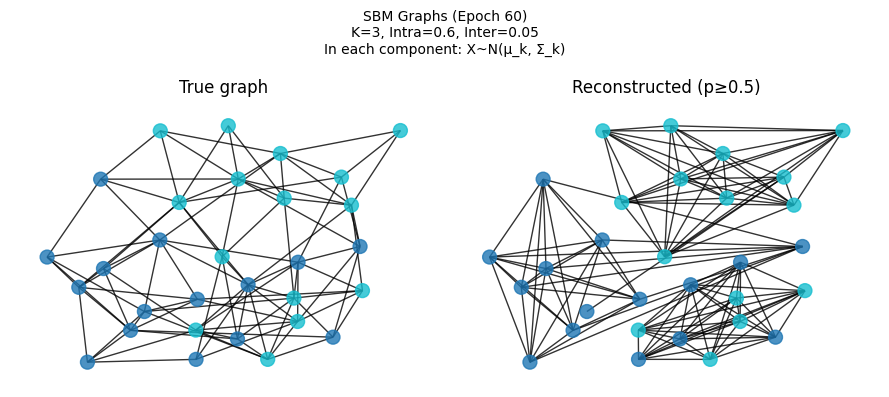

Epoch 061 | Loss: 16857.73 | Recon: 16839.01 | KL: 187.16 | kl_w: 0.1000
Epoch 062 | Loss: 16881.03 | Recon: 16862.61 | KL: 184.24 | kl_w: 0.1000
Epoch 063 | Loss: 16854.68 | Recon: 16835.99 | KL: 186.88 | kl_w: 0.1000
Epoch 064 | Loss: 16731.02 | Recon: 16712.89 | KL: 181.31 | kl_w: 0.1000
Epoch 065 | Loss: 16726.58 | Recon: 16708.10 | KL: 184.79 | kl_w: 0.1000


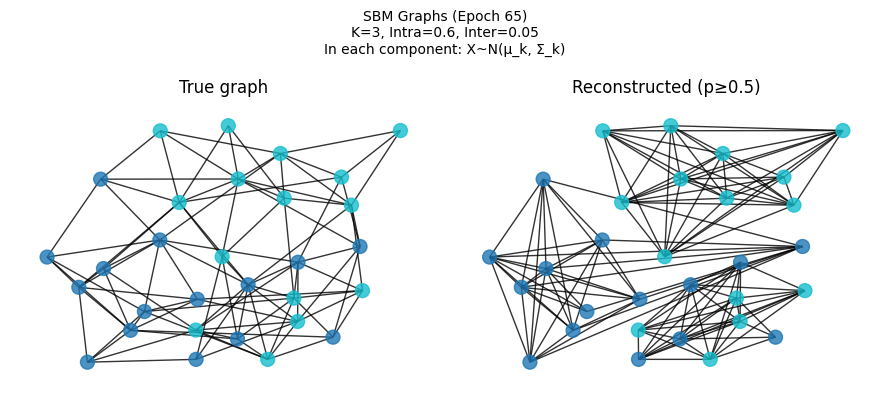

Epoch 066 | Loss: 16605.13 | Recon: 16585.84 | KL: 192.86 | kl_w: 0.1000
Epoch 067 | Loss: 16654.74 | Recon: 16636.28 | KL: 184.58 | kl_w: 0.1000
Epoch 068 | Loss: 16553.33 | Recon: 16535.31 | KL: 180.20 | kl_w: 0.1000
Epoch 069 | Loss: 16587.96 | Recon: 16569.24 | KL: 187.26 | kl_w: 0.1000
Epoch 070 | Loss: 16529.91 | Recon: 16511.57 | KL: 183.47 | kl_w: 0.1000


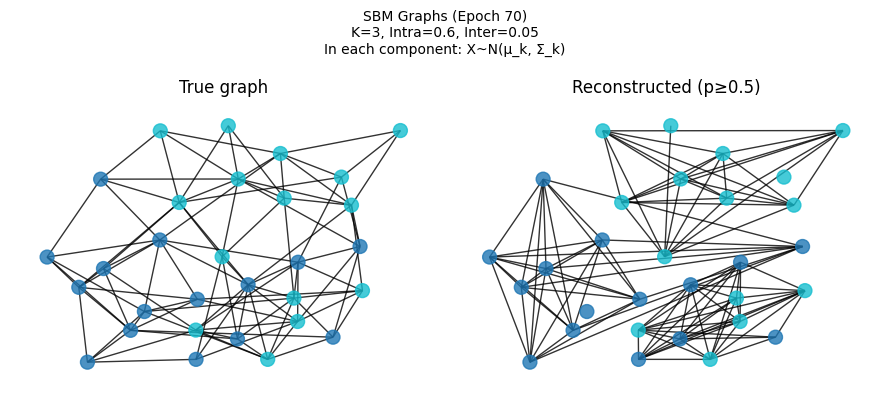

Epoch 071 | Loss: 16483.25 | Recon: 16465.35 | KL: 179.05 | kl_w: 0.1000
Epoch 072 | Loss: 16515.79 | Recon: 16497.64 | KL: 181.43 | kl_w: 0.1000
Epoch 073 | Loss: 16419.89 | Recon: 16401.47 | KL: 184.17 | kl_w: 0.1000
Epoch 074 | Loss: 16408.75 | Recon: 16390.75 | KL: 179.92 | kl_w: 0.1000
Epoch 075 | Loss: 16317.52 | Recon: 16299.62 | KL: 179.03 | kl_w: 0.1000


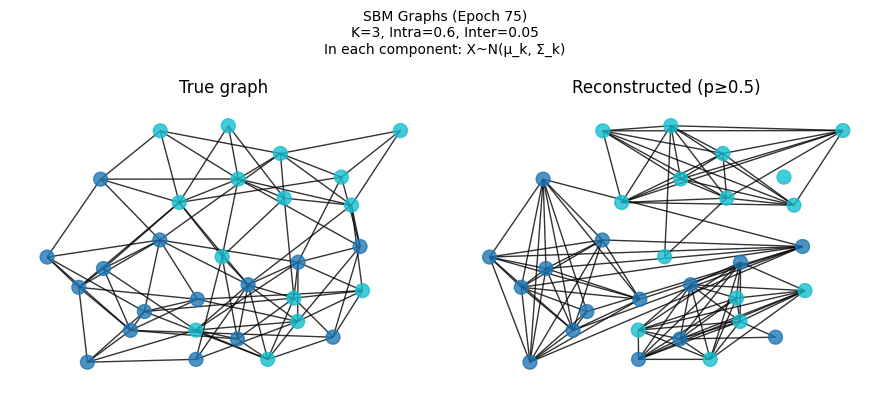

Epoch 076 | Loss: 16398.79 | Recon: 16380.88 | KL: 179.09 | kl_w: 0.1000
Epoch 077 | Loss: 16313.81 | Recon: 16295.34 | KL: 184.68 | kl_w: 0.1000
Epoch 078 | Loss: 16280.35 | Recon: 16261.07 | KL: 192.79 | kl_w: 0.1000
Epoch 079 | Loss: 16209.75 | Recon: 16190.32 | KL: 194.34 | kl_w: 0.1000
Epoch 080 | Loss: 16150.82 | Recon: 16131.57 | KL: 192.47 | kl_w: 0.1000


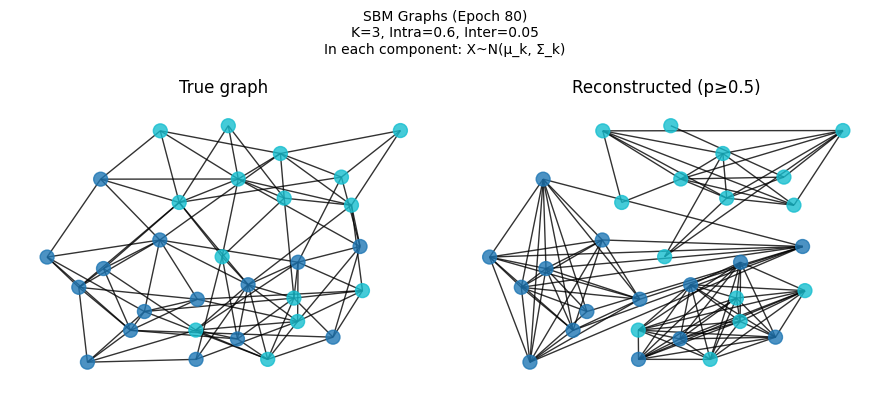

Epoch 081 | Loss: 16003.57 | Recon: 15985.03 | KL: 185.39 | kl_w: 0.1000
Epoch 082 | Loss: 15976.36 | Recon: 15958.29 | KL: 180.71 | kl_w: 0.1000
Epoch 083 | Loss: 15911.02 | Recon: 15891.54 | KL: 194.82 | kl_w: 0.1000
Epoch 084 | Loss: 15835.88 | Recon: 15814.46 | KL: 214.19 | kl_w: 0.1000
Epoch 085 | Loss: 15816.25 | Recon: 15796.61 | KL: 196.44 | kl_w: 0.1000


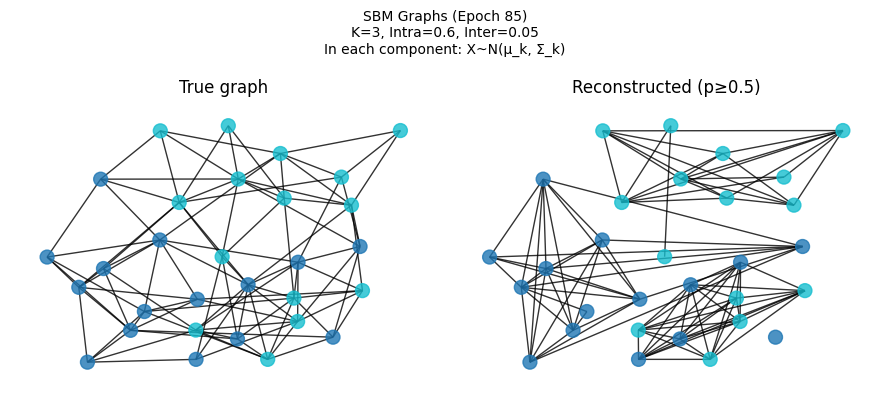

Epoch 086 | Loss: 15704.81 | Recon: 15685.56 | KL: 192.48 | kl_w: 0.1000
Epoch 087 | Loss: 15656.23 | Recon: 15637.28 | KL: 189.56 | kl_w: 0.1000
Epoch 088 | Loss: 15603.59 | Recon: 15584.21 | KL: 193.77 | kl_w: 0.1000
Epoch 089 | Loss: 15619.34 | Recon: 15596.65 | KL: 226.89 | kl_w: 0.1000
Epoch 090 | Loss: 15637.33 | Recon: 15616.64 | KL: 206.87 | kl_w: 0.1000


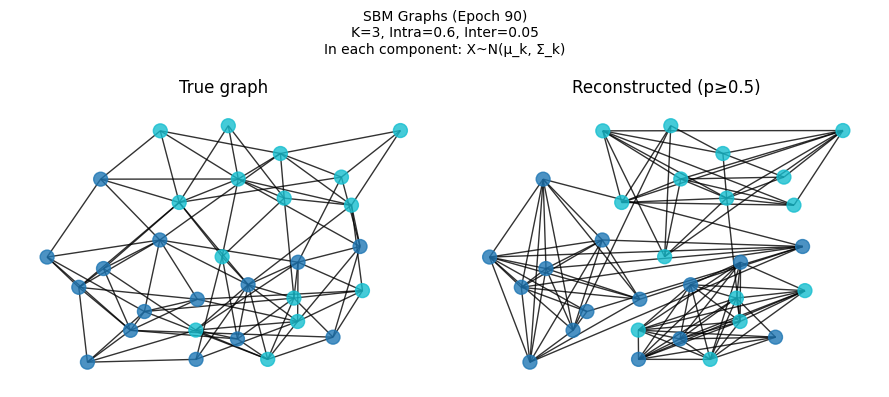

Epoch 091 | Loss: 15573.98 | Recon: 15554.45 | KL: 195.34 | kl_w: 0.1000
Epoch 092 | Loss: 15510.75 | Recon: 15492.23 | KL: 185.19 | kl_w: 0.1000
Epoch 093 | Loss: 15597.18 | Recon: 15577.42 | KL: 197.63 | kl_w: 0.1000
Epoch 094 | Loss: 15566.51 | Recon: 15545.26 | KL: 212.52 | kl_w: 0.1000
Epoch 095 | Loss: 15598.67 | Recon: 15576.21 | KL: 224.56 | kl_w: 0.1000


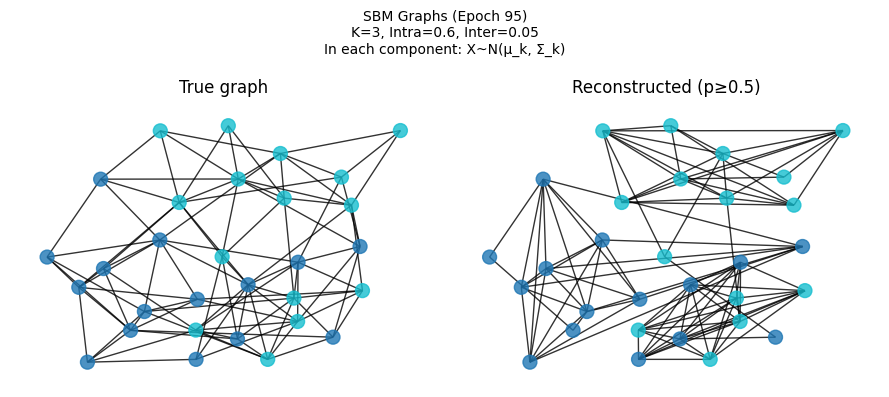

Epoch 096 | Loss: 15554.66 | Recon: 15531.38 | KL: 232.81 | kl_w: 0.1000
Epoch 097 | Loss: 15531.30 | Recon: 15507.15 | KL: 241.58 | kl_w: 0.1000
Epoch 098 | Loss: 15442.74 | Recon: 15421.08 | KL: 216.58 | kl_w: 0.1000
Epoch 099 | Loss: 15401.64 | Recon: 15380.12 | KL: 215.28 | kl_w: 0.1000
Epoch 100 | Loss: 15348.56 | Recon: 15327.90 | KL: 206.64 | kl_w: 0.1000


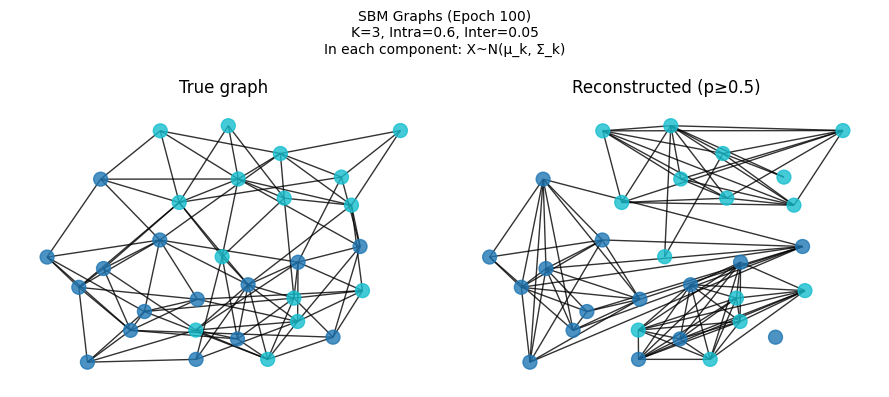

✅ Model saved: temporal_graph_vae_sbm.pth
✅ Model loaded from: temporal_graph_vae_sbm.pth


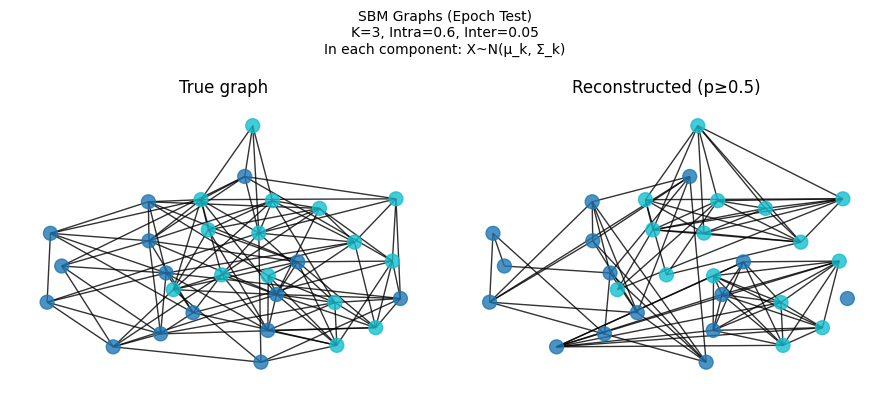

Test accuracy: 0.7311


In [ ]:

if __name__ == "__main__":
    model, dataset = train_model(vis_interval=5, epochs=100)
    test_model(model, dataset)


# Question 2: Conditional Variational Autoencoder (CVAE) for Digit Generation

This note introduces a **Conditional Variational Autoencoder (CVAE)** for image generation on the **MNIST** dataset. The goal is to learn a deep latent-variable model that can synthesize digits conditioned on a desired label—e.g., generate a “2” on demand—and optionally modulate the writing style.


## **Problem setup**

We observe training pairs of handwritten digits and their class labels
$$
\mathcal{D} = {(x^{(i)}, y^{(i)})}_{i=1}^N,
$$
where $x^{(i)} \in \mathbb{R}^{28\times28}$ is an image and $y^{(i)} \in {0,\dots,9}$ is the corresponding digit label.
Our goal is to model the conditional data distribution
$$
p_\theta(x \mid y),
$$
so that, given any label $y$, the model can generate realistic samples $x$ of that digit.



100%|██████████| 9.91M/9.91M [00:00<00:00, 62.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.1MB/s]


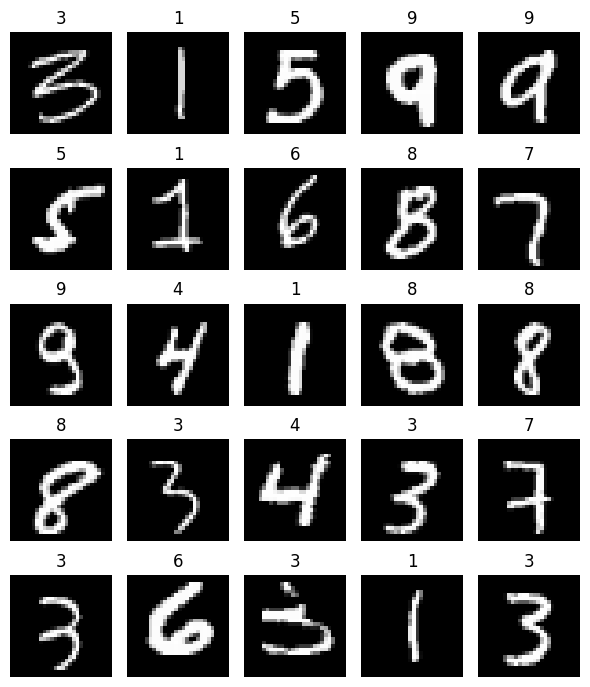

In [1]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

# data visualization
dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

fig, axes = plt.subplots(5, 5, figsize=(6, 7))
indices = torch.randperm(len(dataset))[:25]

for i, ax in enumerate(axes.flat):
    img, label = dataset[indices[i]]
    ax.imshow(img.view(28, 28), cmap='gray')
    ax.set_title(f"{label}")
    ax.axis('off')
plt.tight_layout()
plt.show()

def visualize_results(images, n_rows=5, n_cols=5):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].view(28, 28).numpy(), cmap='gray')
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

### **Model setup**

We introduce a latent variable $ z \in \mathbb{R}^m $ that captures continuous variations in handwriting style.
The joint distribution is defined as

$$
p_\theta(x, z \mid y) = p_\theta(x \mid z, y) p(z),
$$

where $ p(z) = \mathcal{N}(0, I) $ is a fixed Gaussian prior.

* **Decoder (generative model):** $ p_\theta(x \mid z, y) $ reconstructs the image given latent code $z$ and label $y$.
* **Encoder (inference model):** we approximate the true posterior $ p_\theta(z \mid x, y) $ with

$$
q_\phi(z \mid x, y) = \mathcal{N}\big(\mu_\phi(x, y), \mathrm{diag}(\sigma_\phi^2(x, y))\big).
$$



### **Derivation of the Conditional ELBO**

Our goal is to maximize the conditional log-likelihood of the data:

$$
\log p_\theta(x \mid y).
$$

Since this is intractable, we derive a lower bound (the **conditional ELBO**):

$$
\log p_\theta(x \mid y)
\ge
\mathbb{E}_{q_\phi(z \mid x, y)}[\log p_\theta(x \mid z, y)]

D_{\mathrm{KL}}\big(q_\phi(z \mid x, y) | p(z)\big).
$$

### **Training objective**

The right-hand side is the objective we actually optimize.
We **maximize** the ELBO with respect to parameters $\theta$ and $\phi$, or equivalently, **minimize** the negative ELBO (which is used as the loss in code):

$$
\mathcal{L}_{\text{CVAE}}(x, y)
= -\mathbb{E}_{q_\phi(z \mid x, y)}[\log p_\theta(x \mid z, y)]
+ D_{\mathrm{KL}}\big(q_\phi(z \mid x, y) | p(z)\big).
$$

- The first term (reconstruction loss) ensures that decoded samples resemble the input image.
- The second term (KL divergence) regularizes the latent distribution so that it stays close to the Gaussian prior, which keeps sampling stable during generation.




In [2]:
# models
class Encoder(nn.Module):
    def __init__(self, y_dim, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784 + y_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2)
        )
        self.mu = nn.Linear(256, z_dim)
        self.logvar = nn.Linear(256, z_dim)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        h = self.net(x)
        return self.mu(h), self.logvar(h)


class Decoder(nn.Module):
    def __init__(self, y_dim, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + y_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        return self.net(z)


class CVAE(nn.Module):
    def __init__(self, y_dim=10, z_dim=32):
        super().__init__()
        self.y_dim = y_dim
        self.encoder = Encoder(y_dim, z_dim)
        self.decoder = Decoder(y_dim, z_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(-1, 784)
        if y.dim() == 1:
            y = F.one_hot(y, num_classes=self.y_dim).float()
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z, y), mu, logvar

In [3]:
# loss
def loss_function(x_recon, x, mu, logvar):
    # reconstruction loss (binary cross-entropy)
    recon_loss = F.binary_cross_entropy(x_recon, x.view(-1, 784), reduction='sum')

    # KL divergence between q(z|x,y) and N(0,I)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [4]:
# training
# dataloader
batch_size = 128
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(y_dim=10, z_dim=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 100
### don't edit this !!!
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model(x, y)

        loss, recon_loss, kl_loss = loss_function(x_recon, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    n = len(train_loader.dataset)
    print(f"Epoch {epoch:02d}  Loss per example: {total_loss / n:.4f}  Recon: {total_recon / n:.4f}  KL: {total_kl / n:.4f}")

torch.save(model.state_dict(), 'cvae_mnist_strong.pth')

Epoch 01  Loss per example: 131.8632  Recon: 115.2535  KL: 16.6097
Epoch 02  Loss per example: 111.2586  Recon: 92.4431  KL: 18.8155
Epoch 03  Loss per example: 107.3643  Recon: 88.1516  KL: 19.2126
Epoch 04  Loss per example: 105.1886  Recon: 85.8014  KL: 19.3872
Epoch 05  Loss per example: 103.6222  Recon: 84.1852  KL: 19.4370
Epoch 06  Loss per example: 102.4585  Recon: 82.9944  KL: 19.4641
Epoch 07  Loss per example: 101.7609  Recon: 82.2817  KL: 19.4792
Epoch 08  Loss per example: 100.9969  Recon: 81.4986  KL: 19.4984
Epoch 09  Loss per example: 100.4201  Recon: 80.9041  KL: 19.5161
Epoch 10  Loss per example: 99.8537  Recon: 80.2992  KL: 19.5545
Epoch 11  Loss per example: 99.3296  Recon: 79.7735  KL: 19.5561
Epoch 12  Loss per example: 98.8854  Recon: 79.3594  KL: 19.5260
Epoch 13  Loss per example: 98.6106  Recon: 79.0364  KL: 19.5742
Epoch 14  Loss per example: 98.2961  Recon: 78.7341  KL: 19.5621
Epoch 15  Loss per example: 97.8068  Recon: 78.2517  KL: 19.5551
Epoch 16  Loss 

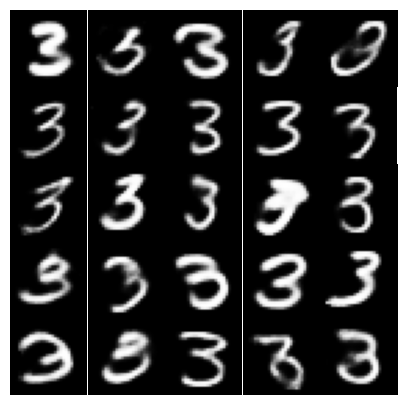

In [7]:
# model inferencing
model.eval()
with torch.no_grad():
    # choose the digit you want to generate
    digit = 3   # for example, "2"
    n = 25
    y = torch.tensor([digit] * n).to(device)
    y = F.one_hot(y, num_classes=10).float()

    # match the latent size to your model (z_dim=32)
    z = torch.randn(n, 32).to(device)

    # decode to images
    x_gen = model.decoder(z, y).cpu()

# visualize
visualize_results(x_gen)

### Student ID Generation
After training your CVAE model, define a function that takes your 9-digit student ID as input and generates one digit per number in your ID. Each digit must be conditioned on its corresponding label (0–9). Arrange the generated digits horizontally in a 1×9 grid to visually display your complete student ID as a sequence of generated MNIST-style digits. Include this final generated image in your report.

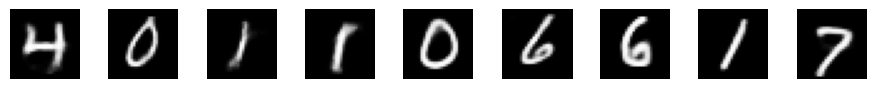

In [14]:
def generate_student_digits(model, student_id, device='cpu'):
    model.eval()
    digits = [int(d) for d in str(student_id)]
    n = len(digits)

    y = torch.tensor(digits).to(device)
    y = F.one_hot(y, num_classes=10).float()

    z = torch.randn(n, 32).to(device)

    with torch.no_grad():
        x_gen = model.decoder(z, y).cpu()

    fig, axes = plt.subplots(1, n, figsize=(n, 1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_gen[i].view(28, 28).numpy(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

generate_student_digits(model, 401106617, device)

### **Latent Space Exploration**
To demonstrate that your CVAE has learned a meaningful latent representation, write a function that visualizes the latent space of the model.
Select **two random latent directions** in $z$-space, fix a target digit label $y$, and generate a **9×9 grid** of samples by varying these two directions from negative to positive values.
The center of the grid should correspond to $z = 0$ (the mean latent vector), while moving along the axes explores different variations of handwriting style.
After visualizing, **describe what each direction appears to represent**—for example, changes in stroke thickness, slant, or digit shape—and discuss whether the transformations look smooth and interpretable.


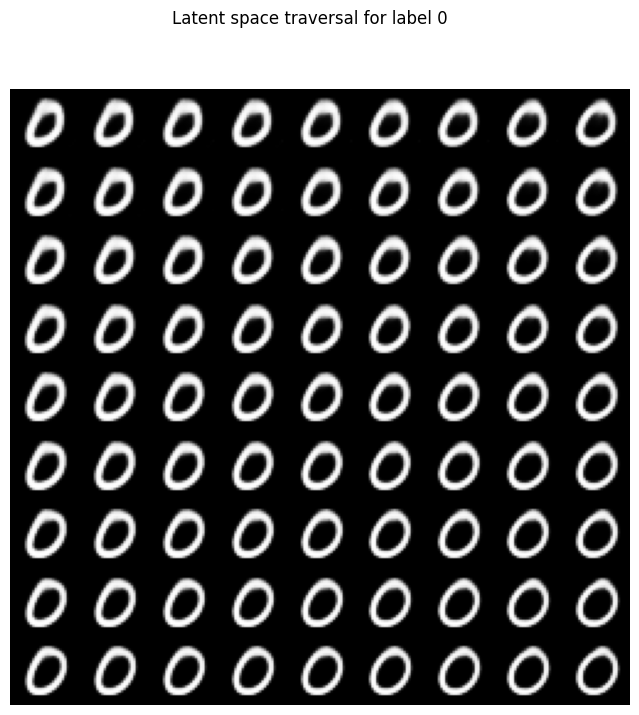

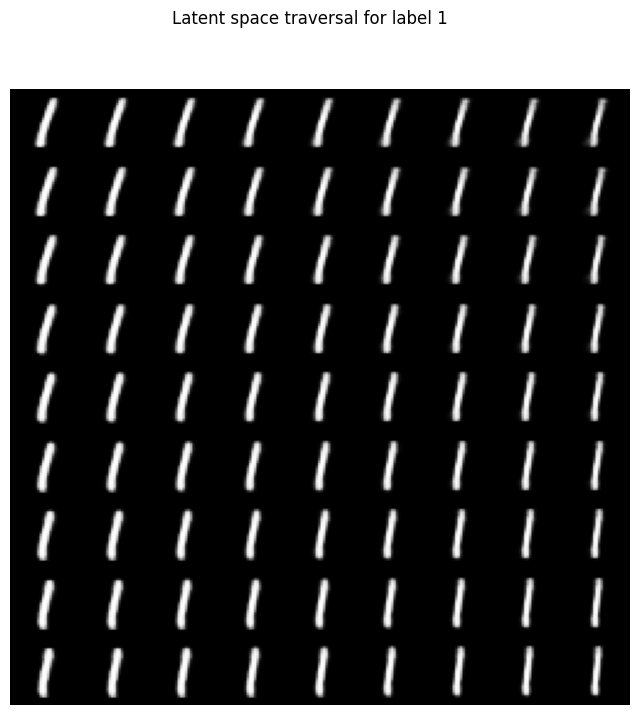

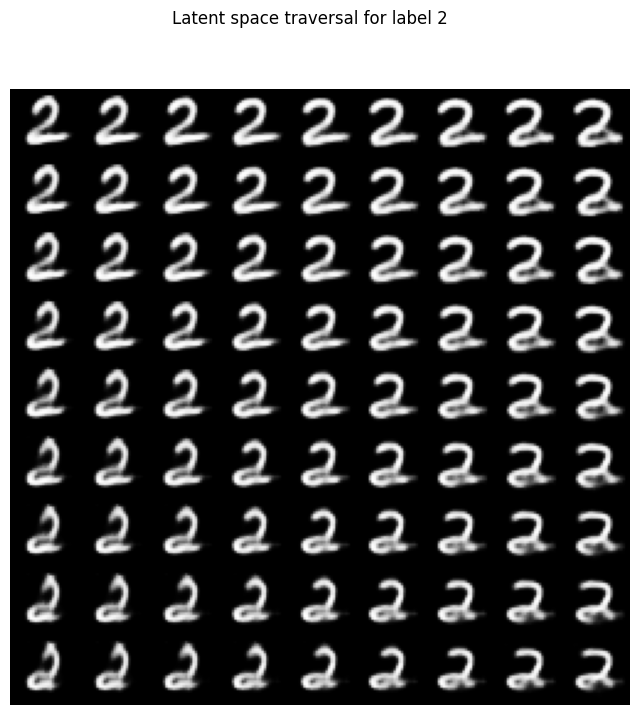

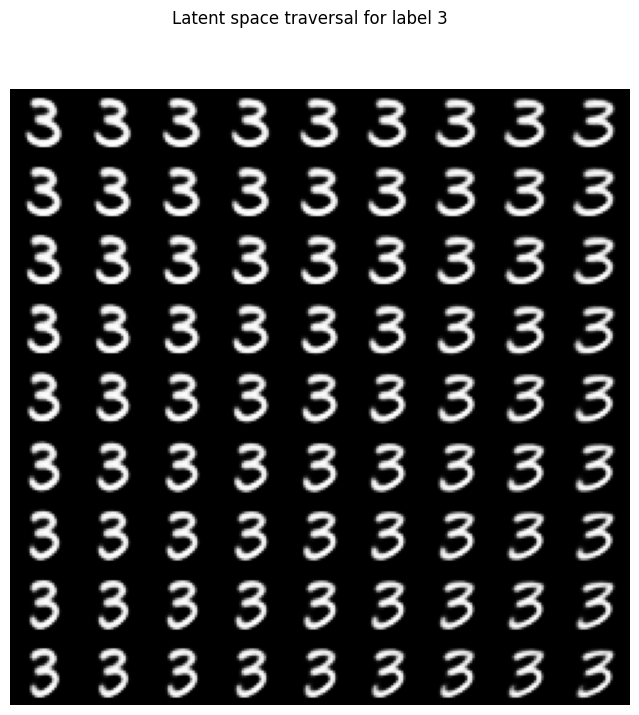

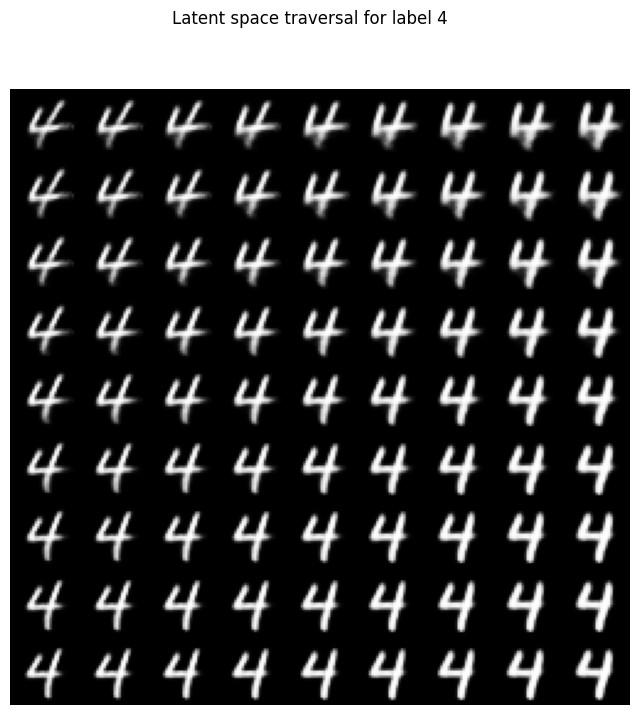

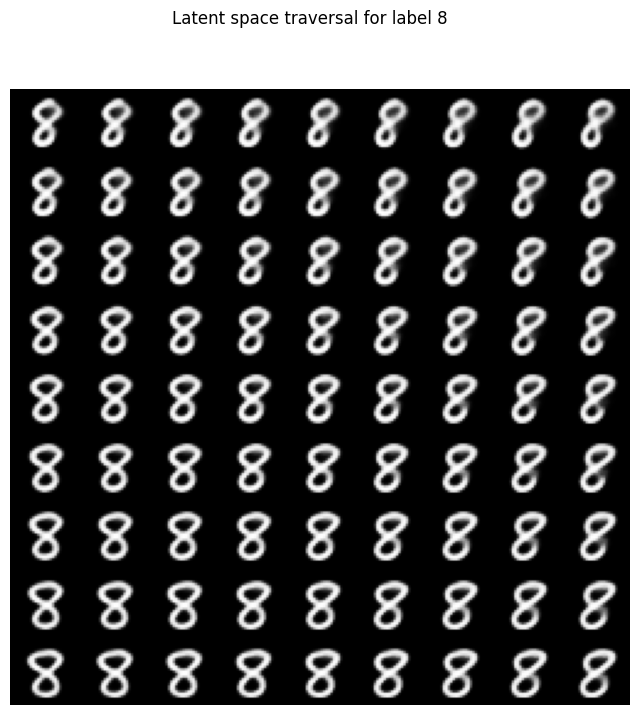

In [15]:
def visualize_latent_space(model, y_label, z_dim=32, grid_size=9, scale=2.0, device='cpu'):
    model.eval()

    v1 = torch.randn(z_dim).to(device)
    v1 = v1 / v1.norm()
    v2 = torch.randn(z_dim).to(device)
    v2 = v2 / v2.norm()

    lin = torch.linspace(-scale, scale, grid_size)
    z_list = []

    for y_val in lin:
        for x_val in lin:
            z_vec = x_val * v1 + y_val * v2
            z_list.append(z_vec)

    z = torch.stack(z_list).to(device)

    y = torch.tensor([y_label] * len(z)).to(device)
    y = F.one_hot(y, num_classes=10).float()

    with torch.no_grad():
        x_gen = model.decoder(z, y).cpu()

    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    plt.suptitle(f"Latent space traversal for label {y_label}")
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_gen[i].view(28, 28).numpy(), cmap='gray')
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

visualize_latent_space(model, 0, device=device)
visualize_latent_space(model, 1, device=device)
visualize_latent_space(model, 2, device=device)
visualize_latent_space(model, 3, device=device)
visualize_latent_space(model, 4, device=device)
visualize_latent_space(model, 8, device=device)



### **Bonus – Style-Controlled Student ID Generation**
Extend your CVAE to allow **style control** along a latent dimension.
Write a function that takes your **9-digit student ID** as input and generates one digit per number, arranged in a single row.
Additionally, for each digit, gradually vary the “style” dimension from thin to thick (or light to bold) as you move across the row, so that the same digit shows different styles.
Include the resulting image in your report and briefly describe how the style changes are reflected in the generated digits.


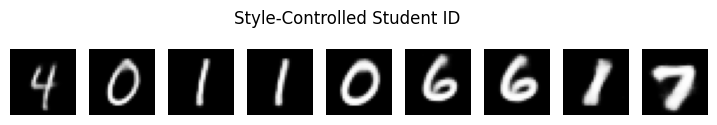

In [16]:
def generate_styled_student_digits(model, student_id, device='cpu'):
    model.eval()

    with torch.no_grad():
        z_sample = torch.randn(1000, 32).to(device)
        y_sample = F.one_hot(torch.randint(0, 10, (1000,)), num_classes=10).float().to(device)
        x_out = model.decoder(z_sample, y_sample)
        mass = x_out.view(1000, -1).sum(dim=1)
        mass = mass - mass.mean()
        direction = (z_sample.T @ mass.unsqueeze(1)).squeeze()
        direction = direction / (direction.norm() + 1e-8)

    digits = [int(d) for d in str(student_id)]
    n = len(digits)

    y = torch.tensor(digits).to(device)
    y = F.one_hot(y, num_classes=10).float()

    scales = torch.linspace(-2.5, 2.5, n).to(device)
    z = torch.outer(scales, direction)

    with torch.no_grad():
        x_gen = model.decoder(z, y).cpu()

    fig, axes = plt.subplots(1, n, figsize=(n, 1.5))
    plt.suptitle("Style-Controlled Student ID")
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_gen[i].view(28, 28).numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

generate_styled_student_digits(model, 401106617, device)

<div style="color: #00008B;">

### Explanation of Style Control

To implement style control, we utilized the latent space properties of the CVAE. Since the model was trained in an unsupervised manner regarding style, there is no explicit "thickness" dimension by default. To find one, we employed an empirical method:

1.  **Direction Discovery:** We sampled a large batch of random latent vectors $z$ and generated their corresponding digit images. We then calculated the "pixel mass" (sum of pixel intensities) for each image to approximate its thickness/boldness. By computing the correlation between the latent variables and this thickness metric, we identified a **"thickness vector"** in the latent space.

2.  **Traversal:** This vector represents the direction of maximum variance in line thickness. To generate the styled student ID, we fixed the digit identity using the label $y$ (corresponding to the student ID numbers) and set the base latent vector to the mean ($z=0$).

3.  **Result:** We then traversed along the discovered thickness vector by adding it to the base $z$ with varying scaling factors (from negative to positive). This forces the decoder to generate the same digit but with varying stroke weights, demonstrating that the model has learned a smooth manifold where structural attributes (like thickness) can be manipulated continuously independent of the digit class.

</div>